In [351]:
import pyodbc


class DataBaseConnection:

    def __init__(self) -> None:
        self.cnxn = None
        self.cursor = None

    def __enter__(self):
        try:
            self.cnxn = pyodbc.connect('''DRIVER={ODBC Driver 17 for SQL Server};
                                        SERVER=analityk.wwsi.edu.pl,50221;
                                        DATABASE=PandemiaCov19;
                                        UID=student;
                                        PWD=ciekawski''',
                                        timeout=3)             
            self.cursor = self.cnxn.cursor()
            return self.cursor
        except pyodbc.OperationalError:
            pass      
            
    def __exit__(self, exc_type, exc_value, exc_tracebac):
        self.cnxn.commit()
        self.cnxn.close()


available_countries = []
with DataBaseConnection() as cursor:
    cursor.execute('''SELECT ID_Country, iso_code FROM Dim_country''')
    available_countries.extend(cursor.fetchall()[1:])


In [353]:
import pandas as pd
import plotly.express as px 
import pyodbc 
import seaborn as sns
from dash import Dash, dcc, html, Input, Output  
from matplotlib import pyplot as plt
from plotly.tools import mpl_to_plotly

# dcc -> dash core components https://dash.plotly.com/dash-core-components
# pltotly.express -> https://plotly.com/python/


app = Dash(__name__)

# -- Import and clean data (importing csv into pandas)
df = pd.read_csv('intro_bees.csv')

df = df.groupby(['State', 'ANSI', 'Affected by', 'Year', 'state_code'])[['Pct of Colonies Impacted']].mean()
df.reset_index(inplace=True)

# ------------------------------------------------------------------------------
# App layout
app.layout = html.Div([

    html.H1('Web Application Dashboards with Dash', style={'text-align': 'center'}),

    html.Div(
        [
            dcc.Dropdown(id='slct_country',    
                        options=[{'label': iso_code, 'value': id_country} for id_country, iso_code in available_countries],
                        multi=True,
                        value=(38, 52, 71, 158, 201),
                        clearable=False,
                        style={'width': '500px'})
        ],
        style = {'display': 'flex', 'align-items': 'center', 'justify-content': 'center', 'width': '100%'}
    ),

    html.Div(id='output_container', style={'text-align': 'center'}),
    html.Br(),

    dcc.Graph(id='first_graphs'),
    dcc.Graph(id='second_graph'),
    dcc.Graph(id='thrid_graph')

])


# ------------------------------------------------------------------------------
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output(component_id='output_container', component_property='children'),
     Output(component_id='first_graphs', component_property='figure'),
     Output(component_id='second_graph', component_property='figure'),
     Output(component_id='thrid_graph', component_property='figure')],
    [Input(component_id='slct_country', component_property='value')]
)
def update_graph(option_slctd):    

    conn = pyodbc.connect(
        '''
        DRIVER={ODBC Driver 17 for SQL Server};
        SERVER=analityk.wwsi.edu.pl,50221;
        DATABASE=PandemiaCov19;
        UID=student;
        PWD=ciekawski;
        '''
        )

    df = pd.read_sql_query(
        f'''
        SELECT Dim_time.Date, 
        Dim_country.iso_code,
        Deaths.new_deaths, Deaths.total_deaths, Deaths.new_deaths_per_milion, Deaths.total_deaths_per_milion, 
        Cases.new_cases, Cases.total_cases, Cases.new_cases_per_million, Cases.total_cases_per_million,
        Tests.new_tests, Tests.total_tests, Tests.new_tests_per_thousand, Tests.total_tests_per_thousand,
        Dim_country.hospital_beds_per_thousand, Dim_country.population_density

        FROM Dim_time INNER JOIN Deaths ON Deaths.ID_Date=Dim_time.ID_Date
                    INNER JOIN Cases ON Cases.ID_Date=Dim_time.ID_Date
                    INNER JOIN Tests ON Tests.ID_Date=Dim_time.ID_Date
                    INNER JOIN Dim_country ON Deaths.ID_Country=Dim_country.ID_Country 
                                            AND Tests.ID_Country=Dim_country.ID_Country 
                                            AND Cases.ID_Country=Dim_country.ID_Country 

        WHERE Dim_country.ID_Country IN ({', '.join(str(id) for id in option_slctd)})
        ORDER BY Dim_time.Date, Dim_country.ID_Country
        ''',
        con=conn, 
        parse_dates={'Dim_time.Date': {'format': '%Y/%m/%d'}},
        index_col='Date'
        )
    
    for id_country, iso_code in available_countries:
        for index, slctd_id in enumerate(option_slctd):
            if id_country == slctd_id:
                option_slctd[index] = iso_code

    container = f'Countries chosen by user: {option_slctd}'

    sns.set(style="ticks", context="talk")

    # Unique countries ISO code
    countries = df['iso_code'].unique()

    # Set date
    df = df[df.index<pd.to_datetime('20220101', format='%Y/%m/%d')]
    df = df[df.index>pd.to_datetime('20200101', format='%Y/%m/%d')]

    # plt.style.use('dark_background')

    # Columns to proceed
    columns_names_to_use = (
        'new_cases_per_million',
        'new_deaths_per_milion',
        'new_tests_per_thousand'
    )

    fig, axes = plt.subplots(
        nrows=len(columns_names_to_use), 
        figsize=(32, 24)
    )
    plot_result = list(range(len(countries)))
    for row_index, column_name in enumerate(columns_names_to_use):
        for index, country in enumerate(countries):        
            data = df[df['iso_code']==f'{country}'].rolling(30, min_periods=1).mean()
            plot_result[index] = sns.lineplot(
                x=data.index.values,
                y=data[f'{column_name}'],
                ax=axes[row_index],
                legend=False,
                palette='pastel'
            )
        axes[row_index].set_title(column_name)
        axes[row_index].legend(
            labels=[country for country in countries], 
            loc='upper left',
            title='Country'
        )

    sns.set_theme(style="whitegrid")
    sns.set_context("talk")

    data = {
        'population_density': [],
        'sum_cases_per_milion': [],
        'sum_deaths_per_milion': [],
        'hospital_beds_per_thousand': [],
        'iso_code': []
    }
    for country in countries:
        temp = df[df['iso_code']==country]
        data['population_density'].append(temp['population_density'].unique()[0])
        data['sum_cases_per_milion'].append(round(temp['new_cases_per_million'].sum())) 
        data['sum_deaths_per_milion'].append(round(temp['new_deaths_per_milion'].sum())) 
        data['hospital_beds_per_thousand'].append(temp['hospital_beds_per_thousand'].unique()[0])
        data['iso_code'].append(country)

    data = pd.DataFrame.from_dict(data)

    fig2 = px.bar(
        data,
        x=data['sum_cases_per_milion'],
        y=data['population_density'],
        color='iso_code',
        )

    fig3 = px.bar(
        data,
        x=data['sum_deaths_per_milion'],
        y=data['hospital_beds_per_thousand'],
        color='iso_code',
        )
        
    plotly_fig = mpl_to_plotly(fig)

    return container, plotly_fig, fig2, fig3


# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server('192.168.0.116', 55554, debug=True, use_reloader=False)

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:

c:\Users\klime\VS Code\dash_python\.venv\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

c:\Users\klime\VS Code\dash_python\.venv\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [6]:
import pyodbc


class DataBaseConnection:

    def __init__(self) -> None:
        self.cnxn = None
        self.cursor = None

    def __enter__(self):
        try:
            self.cnxn = pyodbc.connect('''DRIVER={ODBC Driver 17 for SQL Server};
                                        SERVER=analityk.wwsi.edu.pl,50221;
                                        DATABASE=PandemiaCov19;
                                        UID=student;
                                        PWD=ciekawski''',
                                        timeout=3)             
            self.cursor = self.cnxn.cursor()
            return self.cursor
        except pyodbc.OperationalError:
            pass      
            
    def __exit__(self, exc_type, exc_value, exc_tracebac):
        self.cnxn.commit()
        self.cnxn.close()


with DataBaseConnection() as cursor:
    cursor.execute('''SELECT Date, Deaths.ID_Country, Deaths.new_deaths, Deaths.total_deaths FROM Deaths
                   JOIN Dim_country ON Deaths.ID_Country=Dim_country.ID_Country
                   JOIN Dim_time ON Deaths.ID_Date=Dim_time.ID_Date
                   WHERE Dim_country.ID_Country=158 AND Dim_time.ID_Date<100''')
    data = cursor.fetchall()
    print(data[:5])


[(datetime.date(2020, 3, 4), 158, 0, 0), (datetime.date(2020, 3, 7), 158, 0, 0), (datetime.date(2020, 3, 8), 158, 0, 0), (datetime.date(2020, 3, 9), 158, 0, 0), (datetime.date(2020, 3, 10), 158, 0, 0)]


C:\Users\klime\AppData\Local\Temp/ipykernel_21160/485513686.py:33: DeprecationWarning: PyUnicode_FromUnicode(NULL, size) is deprecated; use PyUnicode_New() instead
  print(data[:5])


In [268]:
import pandas as pd
import pyodbc 

conn = pyodbc.connect(
    '''
    DRIVER={ODBC Driver 17 for SQL Server};
    SERVER=analityk.wwsi.edu.pl,50221;
    DATABASE=PandemiaCov19;
    UID=student;
    PWD=ciekawski;
    '''
    )

df = pd.read_sql_query(
    '''
    SELECT Dim_time.Date, 
    Dim_country.iso_code,
    Deaths.new_deaths, Deaths.total_deaths, Deaths.new_deaths_per_milion, Deaths.total_deaths_per_milion, 
    Cases.new_cases, Cases.total_cases, Cases.new_cases_per_million, Cases.total_cases_per_million,
    Tests.new_tests, Tests.total_tests, Tests.new_tests_per_thousand, Tests.total_tests_per_thousand,
    Dim_country.hospital_beds_per_thousand, Dim_country.population_density

    FROM Dim_time INNER JOIN Deaths ON Deaths.ID_Date=Dim_time.ID_Date
                  INNER JOIN Cases ON Cases.ID_Date=Dim_time.ID_Date
                  INNER JOIN Tests ON Tests.ID_Date=Dim_time.ID_Date
                  INNER JOIN Dim_country ON Deaths.ID_Country=Dim_country.ID_Country 
                                         AND Tests.ID_Country=Dim_country.ID_Country 
                                         AND Cases.ID_Country=Dim_country.ID_Country 

    WHERE Dim_country.ID_Country IN (38, 52, 71, 158, 201)
    ORDER BY Dim_time.Date, Dim_country.ID_Country
    ''',
    con=conn, 
    parse_dates={'Dim_time.Date': {'format': '%Y/%m/%d'}},
    index_col='Date'
    )

df_copy = df.copy()

In [269]:
df[df['iso_code']=='CHN']

,iso_code,new_deaths,total_deaths,new_deaths_per_milion,total_deaths_per_milion,new_cases,total_cases,new_cases_per_million,total_cases_per_million,new_tests,total_tests,new_tests_per_thousand,total_tests_per_thousand,hospital_beds_per_thousand,population_density
Date,,,,,,,,,,,,,,,
2019-12-31,CHN,0,0,0.0,0.00,27,27,0.019,0.019,0,0,0.0,0.0,4.34,147.674
2020-01-01,CHN,0,0,0.0,0.00,0,27,0.000,0.019,0,0,0.0,0.0,4.34,147.674
2020-01-02,CHN,0,0,0.0,0.00,0,27,0.000,0.019,0,0,0.0,0.0,4.34,147.674
2020-01-03,CHN,0,0,0.0,0.00,17,44,0.012,0.031,0,0,0.0,0.0,4.34,147.674
2020-01-04,CHN,0,0,0.0,0.00,0,44,0.000,0.031,0,0,0.0,0.0,4.34,147.674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-15,CHN,0,4636,0.0,3.21,75,100077,0.052,69.295,0,0,0.0,0.0,4.34,147.674
2021-12-16,CHN,0,4636,0.0,3.21,76,100153,0.053,69.348,0,0,0.0,0.0,4.34,147.674
2021-12-17,CHN,0,4636,0.0,3.21,125,100201,0.087,69.381,0,0,0.0,0.0,4.34,147.674


c:\Users\klime\VS Code\dash_python\.venv\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


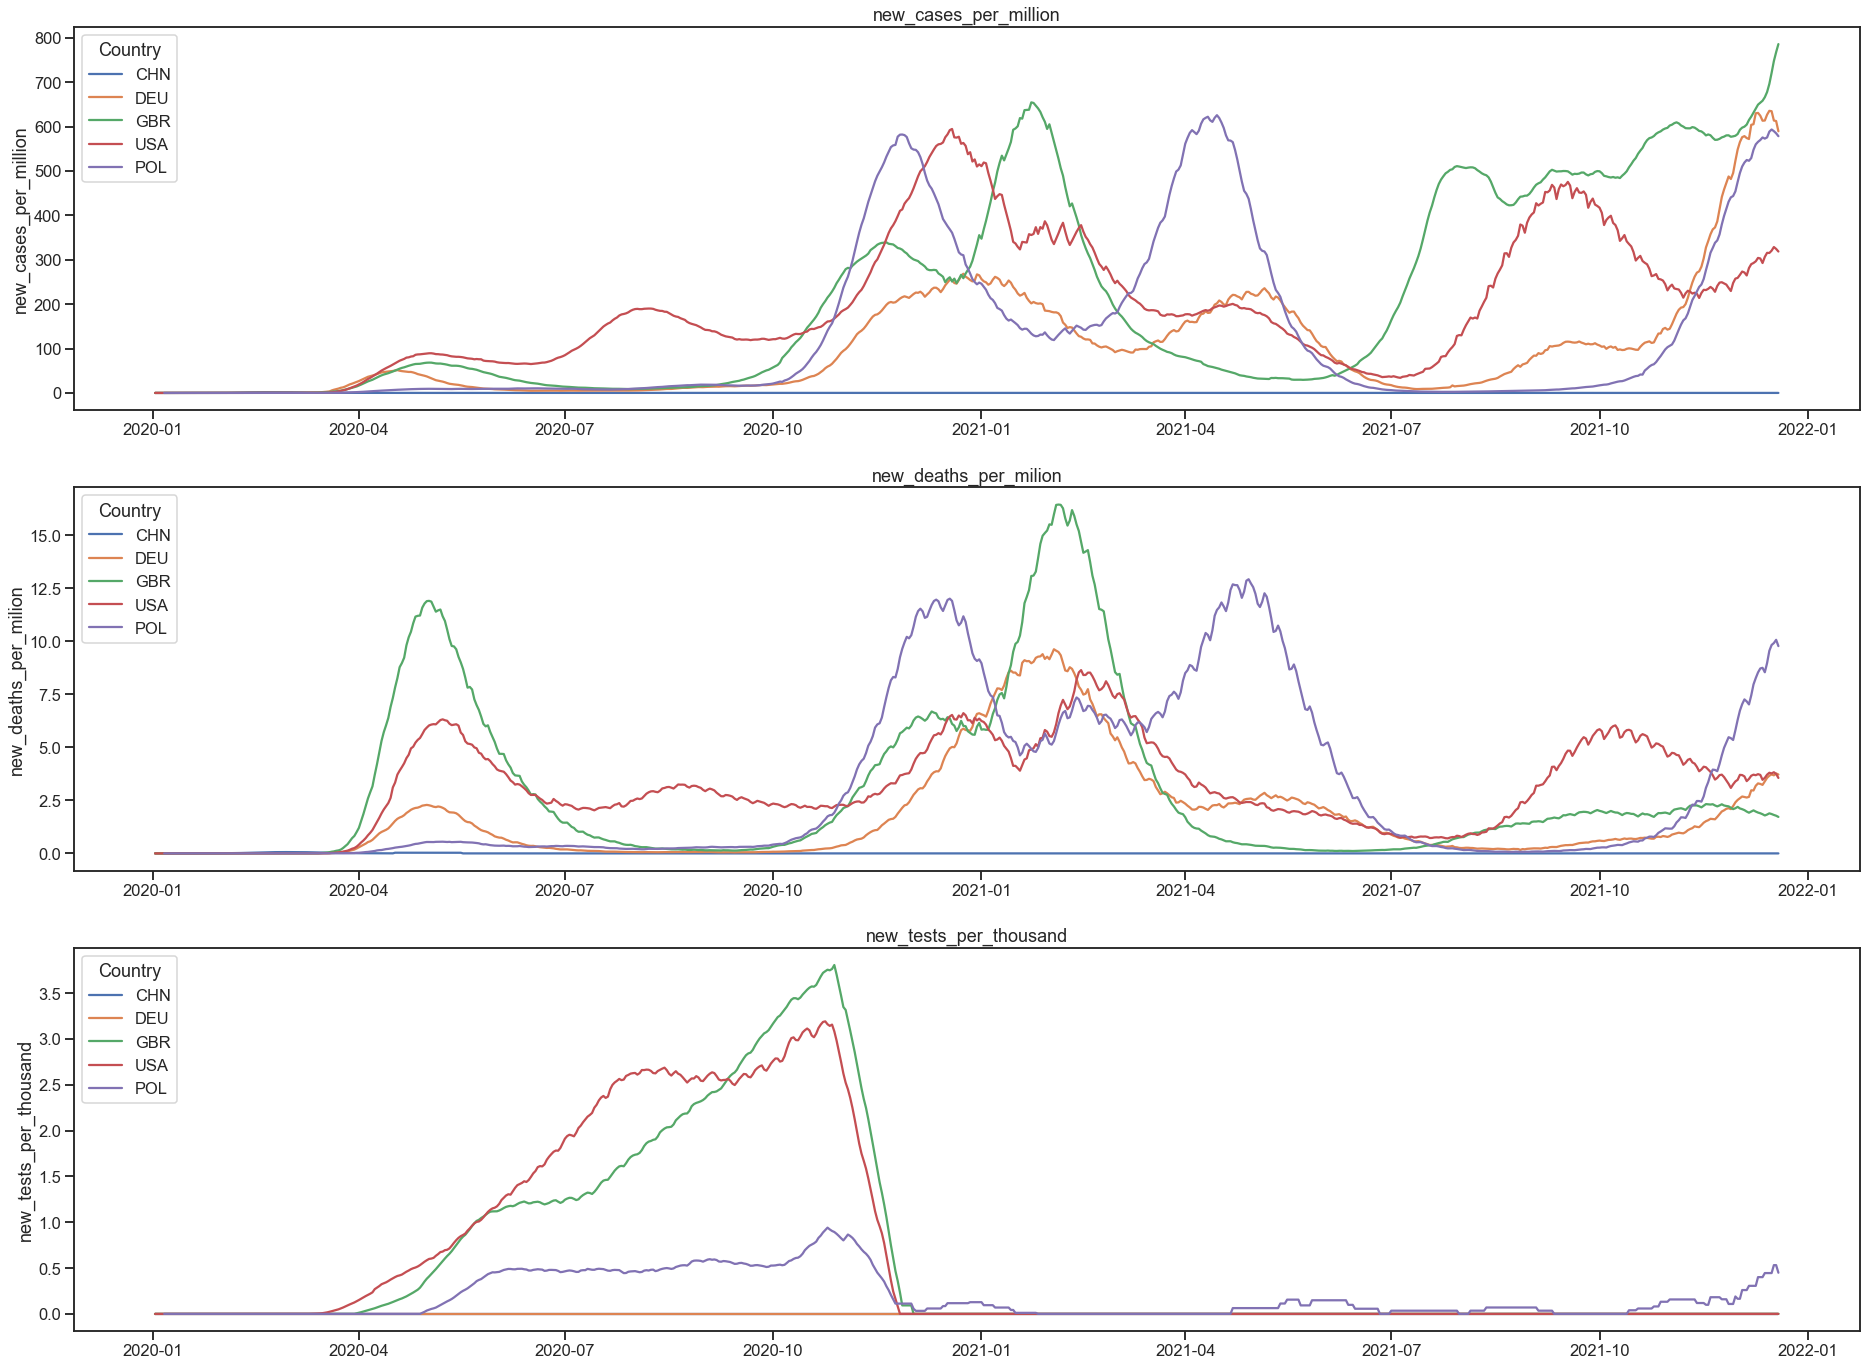

In [265]:
import seaborn as sns
from matplotlib import pyplot as plt

# sns.set_theme(style='dark', palette='dark')
sns.set(style="ticks", context="talk")

df = df_copy.copy()

# Unique countries ISO code
countries = df['iso_code'].unique()

# Set date
df = df[df.index<pd.to_datetime('20220101', format='%Y/%m/%d')]
df = df[df.index>pd.to_datetime('20200101', format='%Y/%m/%d')]

# plt.style.use('dark_background')

# Columns to proceed
columns_names_to_use = (
    'new_cases_per_million',
    'new_deaths_per_milion',
    'new_tests_per_thousand'
)

fig, axes = plt.subplots(
    nrows=len(columns_names_to_use), 
    figsize=(32, 24)
)
plot_result = list(range(len(countries)))
for row_index, column_name in enumerate(columns_names_to_use):
    for index, country in enumerate(countries):        
        data = df[df['iso_code']==f'{country}'].rolling(30, min_periods=1).mean()
        plot_result[index] = sns.lineplot(
            x=data.index.values,
            y=data[f'{column_name}'],
            ax=axes[row_index],
            legend=False,
            palette='pastel'
        )
    axes[row_index].set_title(column_name)
    axes[row_index].legend(
        labels=[country for country in countries], 
        loc='upper left',
        title='Country'
    )

<AxesSubplot:xlabel='sum_deaths_per_milion', ylabel='hospital_beds_per_thousand'>

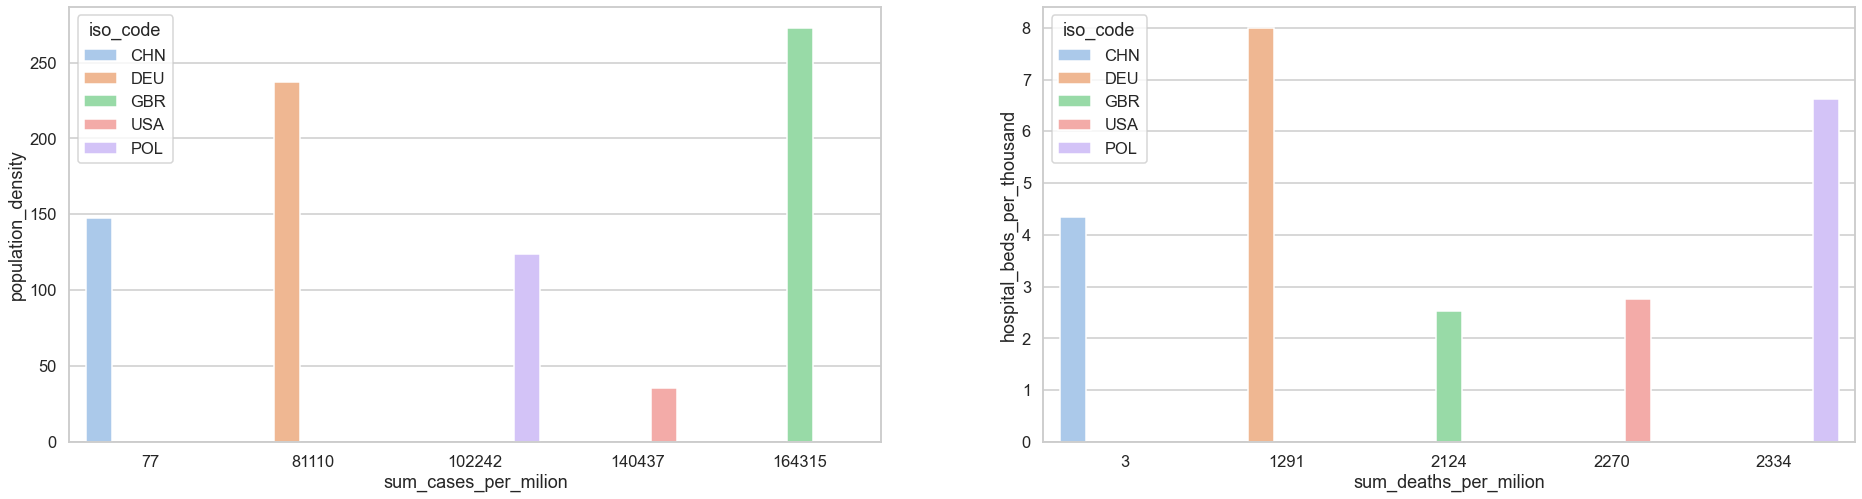

In [303]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")

data = {
    'population_density': [],
    'sum_cases_per_milion': [],
    'sum_deaths_per_milion': [],
    'hospital_beds_per_thousand': [],
    'iso_code': []
}
for country in countries:
    temp = df[df['iso_code']==country]
    data['population_density'].append(temp['population_density'].unique()[0])
    data['sum_cases_per_milion'].append(round(temp['new_cases_per_million'].sum())) 
    data['sum_deaths_per_milion'].append(round(temp['new_deaths_per_milion'].sum())) 
    data['hospital_beds_per_thousand'].append(temp['hospital_beds_per_thousand'].unique()[0])
    data['iso_code'].append(country)

data = pd.DataFrame.from_dict(data)

fig, axes = plt.subplots(
    ncols=2, 
    figsize=(32, 8)
)
sns.barplot(
    x=data['sum_cases_per_milion'],
    y=data['population_density'],
    hue='iso_code',
    data=data,
    ax=axes[0],
    palette='pastel'
    )
sns.barplot(
    x=data['sum_deaths_per_milion'],
    y=data['hospital_beds_per_thousand'],
    hue='iso_code',
    data=data,
    ax=axes[1],
    palette='pastel'
    )
# axes[0].set_yscale('log')

In [304]:
data

,population_density,sum_cases_per_milion,sum_deaths_per_milion,hospital_beds_per_thousand,iso_code
0,147.674,77,3,4.34,CHN
1,237.016,81110,1291,8.00,DEU
2,272.898,164315,2124,2.54,GBR
3,35.608,140437,2270,2.77,USA
4,124.027,102242,2334,6.62,POL


In [344]:
import pandas as pd
import plotly.express as px 
import pyodbc 
import seaborn as sns
from dash import Dash, dcc, html, Input, Output  
from matplotlib import pyplot as plt
from plotly.tools import mpl_to_plotly
from io import BytesIO
import base64

def fig_to_uri(in_fig, close_all=True, **save_args):
    """
    Save a figure as a URI
    :param in_fig:
    :return:
    """
    out_img = BytesIO()
    in_fig.savefig(out_img, format='png', **save_args)
    if close_all:
        in_fig.clf()
        plt.close('all')
    out_img.seek(0)  # rewind file
    encoded = base64.b64encode(out_img.read()).decode("ascii").replace("\n", "")
    return "data:image/png;base64,{}".format(encoded)

# dcc -> dash core components https://dash.plotly.com/dash-core-components
# pltotly.express -> https://plotly.com/python/


app = Dash(__name__)

# -- Import and clean data (importing csv into pandas)
df = pd.read_csv('intro_bees.csv')

df = df.groupby(['State', 'ANSI', 'Affected by', 'Year', 'state_code'])[['Pct of Colonies Impacted']].mean()
df.reset_index(inplace=True)

# ------------------------------------------------------------------------------
# App layout
app.layout = html.Div([

    html.H1('Web Application Dashboards with Dash', style={'text-align': 'center'}),

    html.Div(
        [
            dcc.Dropdown(id='slct_country',    
                        options=[{'label': iso_code, 'value': id_country} for id_country, iso_code in available_countries],
                        multi=True,
                        value=(38, 52, 71, 158, 201),
                        clearable=False,
                        style={'width': '500px'})
        ],
        style = {'display': 'flex', 'align-items': 'center', 'justify-content': 'center', 'width': '100%'}
    ),

    html.Div(id='output_container', style={'text-align': 'center'}),
    html.Br(),  

    html.Div([html.Img(id='first_graphs', src='')],
        style={'backgroundColor':'white'},
        id='plot_div1'),

    html.Div([html.Img(id='second_graphs', src='')],
        style={'backgroundColor':'white'},
        id='plot_div2')    

    # dcc.Graph(id='first_graphs'),
    # dcc.Graph(id='second_graphs')

])


# ------------------------------------------------------------------------------
# Connect the Plotly graphs with Dash Components
@app.callback(
    [Output(component_id='output_container', component_property='children'),
     Output(component_id='first_graphs', component_property='src'),
     Output(component_id='second_graphs', component_property='src')],
    [Input(component_id='slct_country', component_property='value')]
)
def update_graph(option_slctd):    

    conn = pyodbc.connect(
        '''
        DRIVER={ODBC Driver 17 for SQL Server};
        SERVER=analityk.wwsi.edu.pl,50221;
        DATABASE=PandemiaCov19;
        UID=student;
        PWD=ciekawski;
        '''
        )

    df = pd.read_sql_query(
        f'''
        SELECT Dim_time.Date, 
        Dim_country.iso_code,
        Deaths.new_deaths, Deaths.total_deaths, Deaths.new_deaths_per_milion, Deaths.total_deaths_per_milion, 
        Cases.new_cases, Cases.total_cases, Cases.new_cases_per_million, Cases.total_cases_per_million,
        Tests.new_tests, Tests.total_tests, Tests.new_tests_per_thousand, Tests.total_tests_per_thousand,
        Dim_country.hospital_beds_per_thousand, Dim_country.population_density

        FROM Dim_time INNER JOIN Deaths ON Deaths.ID_Date=Dim_time.ID_Date
                    INNER JOIN Cases ON Cases.ID_Date=Dim_time.ID_Date
                    INNER JOIN Tests ON Tests.ID_Date=Dim_time.ID_Date
                    INNER JOIN Dim_country ON Deaths.ID_Country=Dim_country.ID_Country 
                                            AND Tests.ID_Country=Dim_country.ID_Country 
                                            AND Cases.ID_Country=Dim_country.ID_Country 

        WHERE Dim_country.ID_Country IN ({', '.join(str(id) for id in option_slctd)})
        ORDER BY Dim_time.Date, Dim_country.ID_Country
        ''',
        con=conn, 
        parse_dates={'Dim_time.Date': {'format': '%Y/%m/%d'}},
        index_col='Date'
        )
    
    for id_country, iso_code in available_countries:
        for index, slctd_id in enumerate(option_slctd):
            if id_country == slctd_id:
                option_slctd[index] = iso_code

    container = f'Countries chosen by user: {option_slctd}'

    sns.set(style="ticks", context="talk")

    # Unique countries ISO code
    countries = df['iso_code'].unique()

    # Set date
    df = df[df.index<pd.to_datetime('20220101', format='%Y/%m/%d')]
    df = df[df.index>pd.to_datetime('20200101', format='%Y/%m/%d')]

    # plt.style.use('dark_background')

    # Columns to proceed
    columns_names_to_use = (
        'new_cases_per_million',
        'new_deaths_per_milion',
        'new_tests_per_thousand'
    )

    fig, axes = plt.subplots(
        nrows=len(columns_names_to_use), 
        figsize=(32, 24)
    )
    plot_result = list(range(len(countries)))
    for row_index, column_name in enumerate(columns_names_to_use):
        for index, country in enumerate(countries):        
            data = df[df['iso_code']==f'{country}'].rolling(30, min_periods=1).mean()
            plot_result[index] = sns.lineplot(
                x=data.index.values,
                y=data[f'{column_name}'],
                ax=axes[row_index],
                legend=False,
                palette='pastel'
            )
        axes[row_index].set_title(column_name)
        axes[row_index].legend(
            labels=[country for country in countries], 
            loc='upper left',
            title='Country'
        )

    sns.set_theme(style="whitegrid")
    sns.set_context("talk")

    data = {
        'population_density': [],
        'sum_cases_per_milion': [],
        'sum_deaths_per_milion': [],
        'hospital_beds_per_thousand': [],
        'iso_code': []
    }
    for country in countries:
        temp = df[df['iso_code']==country]
        data['population_density'].append(temp['population_density'].unique()[0])
        data['sum_cases_per_milion'].append(round(temp['new_cases_per_million'].sum())) 
        data['sum_deaths_per_milion'].append(round(temp['new_deaths_per_milion'].sum())) 
        data['hospital_beds_per_thousand'].append(temp['hospital_beds_per_thousand'].unique()[0])
        data['iso_code'].append(country)

    data = pd.DataFrame.from_dict(data)

    fig2, axes = plt.subplots(
        ncols=2, 
        figsize=(32, 8)
    )
    sns.barplot(
        x=data['sum_cases_per_milion'],
        y=data['population_density'],
        hue='iso_code',
        data=data,
        ax=axes[0],
        palette='pastel'
        )
    sns.barplot(
        x=data['sum_deaths_per_milion'],
        y=data['hospital_beds_per_thousand'],
        hue='iso_code',
        data=data,
        ax=axes[1],
        palette='pastel'
        )
        
    plotly_fig = fig_to_uri(fig)
    plotly_fig2 = fig_to_uri(fig2)

    return container, plotly_fig, plotly_fig2


# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server('192.168.0.116', 55554, debug=True, use_reloader=False)

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

Dash is running on http://192.168.0.116:55554/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


c:\Users\klime\VS Code\dash_python\.venv\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

